In [1]:
# basic imports
import numpy as np
import IPython
import librosa

import torch

from music2latent.hparams import HParams
from music2latent.hparams_inference import *

device = "mps"

/Users/jasperrr/miniforge3/envs/pt25/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from music2latent.config_loader import load_config
config = 'config.py'
hparams = load_config(config)

In [3]:
import os

from music2latent.export import ScriptedUNet

from music2latent.ema import ExponentialMovingAverage
# filepath = os.path.abspath(__file__)
# lib_root = os.path.dirname(filepath)

# load_path_inference_default = os.path.join(lib_root, 'models/music2latent.pt')

load_path = 'music2latent/models/music2latent.pt'

In [4]:
gen = ScriptedUNet(hparams, sigma_rescale = sigma_rescale).to(device)

checkpoint = torch.load(load_path, map_location=device)
gen.load_state_dict(checkpoint['gen_state_dict'], strict=False)
# if checkpoint['ema_state_dict'] exists, init ema model and load ema_state_dict
if 'ema_state_dict' in checkpoint:
    ema = ExponentialMovingAverage(gen.parameters(), decay=hparams.ema_momentum)
    ema.load_state_dict(checkpoint['ema_state_dict'])
    ema.copy_to()
    with ema.average_parameters():
        checkpoint['gen_state_dict'] = gen.state_dict()
gen.load_state_dict(checkpoint['gen_state_dict'], strict=False)

/var/folders/5p/f0ps7gc956zdqxpd74pybgq80000gn/T/ipykernel_15483/3556767265.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_locati

_IncompatibleKeys(missing_keys=['forward_params'], unexpected_keys=[])

In [5]:
gen.layers_list

[2, 2, 2, 2, 2]

In [6]:
checkpoint['gen_state_dict'].keys()  # print keys of gen_state_dict

odict_keys(['encoder.gain.scale', 'encoder.conv_inp.weight', 'encoder.conv_inp.bias', 'encoder.prenorm_1d_to_2d.weight', 'encoder.prenorm_1d_to_2d.bias', 'encoder.bottleneck_layers.0.weight', 'encoder.bottleneck_layers.0.bias', 'encoder.bottleneck_layers.1.conv1.weight', 'encoder.bottleneck_layers.1.conv1.bias', 'encoder.bottleneck_layers.1.conv2.weight', 'encoder.bottleneck_layers.1.conv2.bias', 'encoder.bottleneck_layers.1.norm1.weight', 'encoder.bottleneck_layers.1.norm1.bias', 'encoder.bottleneck_layers.1.norm2.weight', 'encoder.bottleneck_layers.1.norm2.bias', 'encoder.bottleneck_layers.2.conv1.weight', 'encoder.bottleneck_layers.2.conv1.bias', 'encoder.bottleneck_layers.2.conv2.weight', 'encoder.bottleneck_layers.2.conv2.bias', 'encoder.bottleneck_layers.2.norm1.weight', 'encoder.bottleneck_layers.2.norm1.bias', 'encoder.bottleneck_layers.2.norm2.weight', 'encoder.bottleneck_layers.2.norm2.bias', 'encoder.bottleneck_layers.3.conv1.weight', 'encoder.bottleneck_layers.3.conv1.bias'

In [7]:
gen.down_layers

ModuleList(
  (0): ScriptedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (1): ScriptedResBlockProj(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (res_conv): Identity()
    (norm1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (norm2): GroupNorm(16, 64, eps=1e-05, affine=True)
    (activation): SiLU()
    (proj_emb): Linear(in_features=256, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (att): Identity()
  )
  (2): ScriptedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (3): ScriptedResBlockProj(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (res_conv): Identity()
    (norm1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (norm2): GroupNorm(16, 64, eps=1e-05, affine=True)
    (activation): SiLU()
    (proj_emb): Linear(in_fea

In [8]:
len(gen.down_layers)

24

In [8]:
scripted = torch.jit.script(gen)

/Users/jasperrr/miniforge3/envs/pt25/lib/python3.12/site-packages/torch/jit/_recursive.py:321: UserWarning: 'mods' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn(


In [9]:
gen.export_to_ts("music2latent/models/music2latent-scripted.ts")

In [10]:
import torch
import os

audio_path = librosa.example('trumpet')

In [11]:
%%time 

wv, sr = librosa.load(audio_path, sr=44100)
# print(f'waveform samples: {wv.shape}')

wv = torch.tensor(wv, device=device).unsqueeze(0)#.unsqueeze(0)
# latent = encdec.encode(wv.to(device))
# print(f'Shape of latents: {latent.shape}')
print(f'waveform samples: {wv.shape}')

waveform samples: torch.Size([1, 235202])
CPU times: user 447 ms, sys: 95.4 ms, total: 542 ms
Wall time: 622 ms


In [12]:
downscaling_factor = 2**hparams.freq_downsample_list.count(0)
max_sample_length = (int(max_waveform_length_encode/hparams.hop)//downscaling_factor)*downscaling_factor
cropped_length = ((((42496-3*hparams.hop)//hparams.hop)//downscaling_factor)*hparams.hop*downscaling_factor)+3*hparams.hop
cropped_length

42496

In [13]:
import torch
from music2latent.scripted_audio import wv2realimag, realimag2wv, denormalize_complex, overlap_and_add, inverse_stft_window
import matplotlib.pyplot as plt


In [14]:
repr_encoder = wv2realimag(wv, hparams.hop, 4)

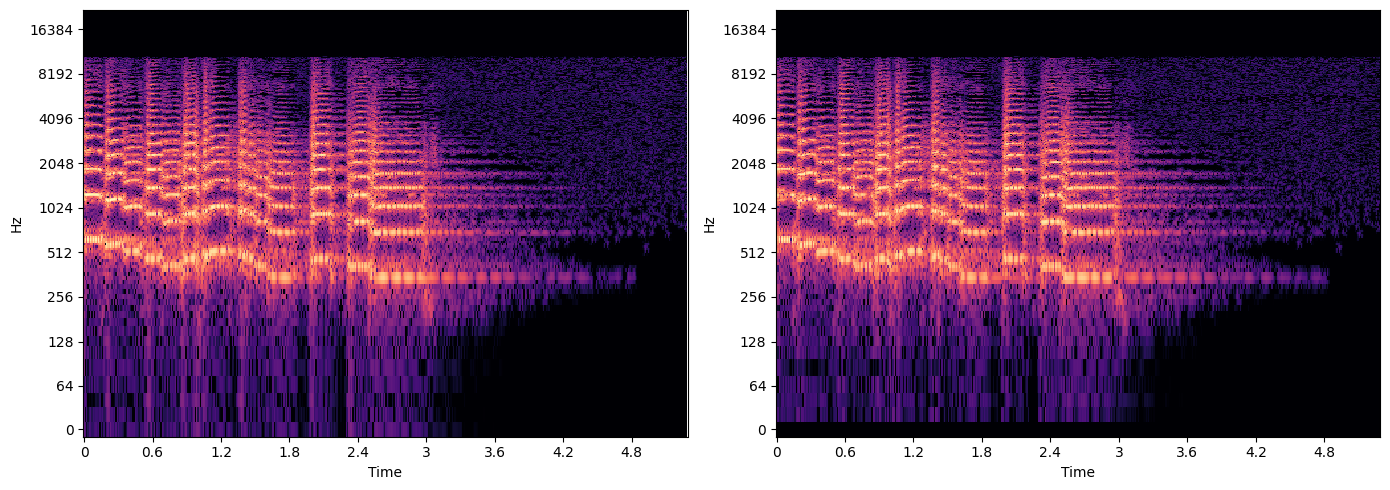

In [15]:
# D = librosa.amplitude_to_db(np.abs(librosa.stft(train_data[0][0].cpu().detach().numpy(), n_fft=2048*4)), ref=np.max)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
img = librosa.display.specshow(librosa.amplitude_to_db(repr_encoder[0,0].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[0], sr=44100)
times = librosa.times_like(repr_encoder[0,0].cpu().numpy(), sr=sr)
img = librosa.display.specshow(librosa.amplitude_to_db(repr_encoder[0,1].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[1], sr=44100)

plt.tight_layout()
plt.show()

In [16]:
max_sample_length = (int(max_waveform_length_encode/hparams.hop)//downscaling_factor)*downscaling_factor
sample_length = repr_encoder.shape[-1]
print(f'max sample length: {max_sample_length}, sample length: {sample_length}, repr_encoder.shape: {repr_encoder.shape}')

max sample length: 5160, sample length: 456, repr_encoder.shape: torch.Size([1, 2, 1024, 456])


In [17]:
%%time

x = gen.encoder.conv_inp(repr_encoder)
if hparams.frequency_scaling:
    x = gen.encoder.gain(x)

# DOWNSAMPLING
k = 0
for i,num_layers in enumerate(gen.encoder.layers_list):
    for num in range(num_layers):
        x = gen.encoder.down_layers[k](x)
        k = k+1
    if i!=(len(gen.encoder.layers_list)-1):
        x = gen.encoder.down_layers[k](x)
        k = k+1

if hparams.pre_normalize_2d_to_1d:
    x = gen.encoder.prenorm_1d_to_2d(x)

x = x.reshape(x.size(0), x.size(1) * x.size(2), x.size(3))

for layer in gen.encoder.bottleneck_layers:
    x = layer(x)
        
x = gen.encoder.norm_out(x)
x = gen.encoder.activation_out(x)
x = gen.encoder.conv_out(x)
x = gen.encoder.activation_bottleneck(x)

latent = x/sigma_rescale

CPU times: user 291 ms, sys: 126 ms, total: 417 ms
Wall time: 355 ms


In [18]:
latent.shape

torch.Size([1, 64, 57])

In [19]:
def get_sigma(i, k):
    return (hparams.sigma_min**(1./hparams.rho) + ((i-1)/(k-1))*(hparams.sigma_max**(1./hparams.rho)-hparams.sigma_min**(1./hparams.rho)))**hparams.rho

sigma = get_sigma(1+1-0, 1+1)
sigma

80.0

In [20]:
def get_c(sigma):
    sigma_correct = hparams.sigma_min
    c_skip = (hparams.sigma_data**2.)/(((sigma-sigma_correct)**2.) + (hparams.sigma_data**2.))
    c_out = (hparams.sigma_data*(sigma-sigma_correct))/(((hparams.sigma_data**2.) + (sigma**2.))**0.5)
    c_in = 1./(((sigma**2.)+(hparams.sigma_data**2.))**0.5)
    return c_skip.reshape(-1,1,1,1), c_out.reshape(-1,1,1,1), c_in.reshape(-1,1,1,1)

def customised_decode(latent, sigma):
    latent = latent*sigma_rescale
    
    num_samples = latent.shape[0]
    downscaling_factor = 2**hparams.freq_downsample_list.count(0)
    sample_length = int(latent.shape[-1]*downscaling_factor)

    x = torch.randn((num_samples, hparams.data_channels, hparams.hop*2, sample_length)).to(device)*hparams.sigma_max

    with torch.no_grad():
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=hparams.mixed_precision):
            if sigma is None:
                sigma = hparams.sigma_max
            
            inp = x
            
            # CONDITIONING
            sigma = torch.ones((x.shape[0],), dtype=torch.float32).to(x.device)*sigma
            sigma_log = torch.log(sigma)/4.
            emb_sigma_log = gen.emb(sigma_log)
            time_emb = gen.emb_proj(emb_sigma_log)

            scale_w_inp = gen.scale_inp(emb_sigma_log).reshape(x.shape[0],1,-1,1)
            scale_w_out = gen.scale_out(emb_sigma_log).reshape(x.shape[0],1,-1,1)
                
            c_skip, c_out, c_in = get_c(sigma)
            
            x = c_in*x

            pyramid_latents = gen.decoder(latent)

            x = gen.conv_inp(x)
            if hparams.frequency_scaling: # true
                x = (1.+scale_w_inp)*x
            
            skip_list = []
            
            # DOWNSAMPLING
            k = 0
            for i,num_layers in enumerate(gen.layers_list):
                for num in range(num_layers):
                    d = gen.down_layers[k](pyramid_latents[i])
                    k = k+1
                    x = (x+d)/np.sqrt(2.)
                    x = gen.down_layers[k]((x, time_emb))
                    skip_list.append(x)
                    k = k+1
                if i!=(len(gen.layers_list)-1):
                    x = gen.down_layers[k](x)
                    k = k+1
                
            # UPSAMPLING
            k = 0
            for i,num_layers in enumerate(reversed(gen.layers_list)):
                for num in range(num_layers):
                    d = gen.up_layers[k](pyramid_latents[-i-1])
                    k = k+1
                    x = (x+skip_list.pop()+d)/np.sqrt(3.)
                    x = gen.up_layers[k]((x, time_emb))
                    k = k+1
                if i!=(len(gen.layers_list)-1):
                    x = gen.up_layers[k](x)
                    k = k+1
                    
            d = gen.conv_decoded(pyramid_latents[0])
            x = (x+d)/np.sqrt(2.)

            x = gen.norm_out(x)
            x = gen.activation_out(x)
            if hparams.frequency_scaling:
                x = (1.+scale_w_out)*x
            x = gen.conv_out(x)

            out = c_skip*inp + c_out*x 
    return out

In [21]:
latent.shape

torch.Size([1, 64, 57])

In [22]:
# latent = torch.cat([latent[:,:,:1]]*57, dim=2)

In [23]:
# latent = latent/sigma_rescale

In [24]:
latent.shape

torch.Size([1, 64, 57])

In [25]:
%%time

with torch.no_grad():
    spec_recs = []
    for i in range(6):
        # spec_rec_i = customised_decode(latent[:,:,i*8:(i+1)*8], sigma)
        wv_rec_i = gen.decode(latent[:,:,i*8:(i+1)*8]).unsqueeze(0)
        spec_recs.append(wv_rec_i)
    wv_rec = torch.cat(spec_recs, dim=-1)
    wv_rec.shape

CPU times: user 2.17 s, sys: 849 ms, total: 3.02 s
Wall time: 540 ms


NameError: name 'spec_rec' is not defined

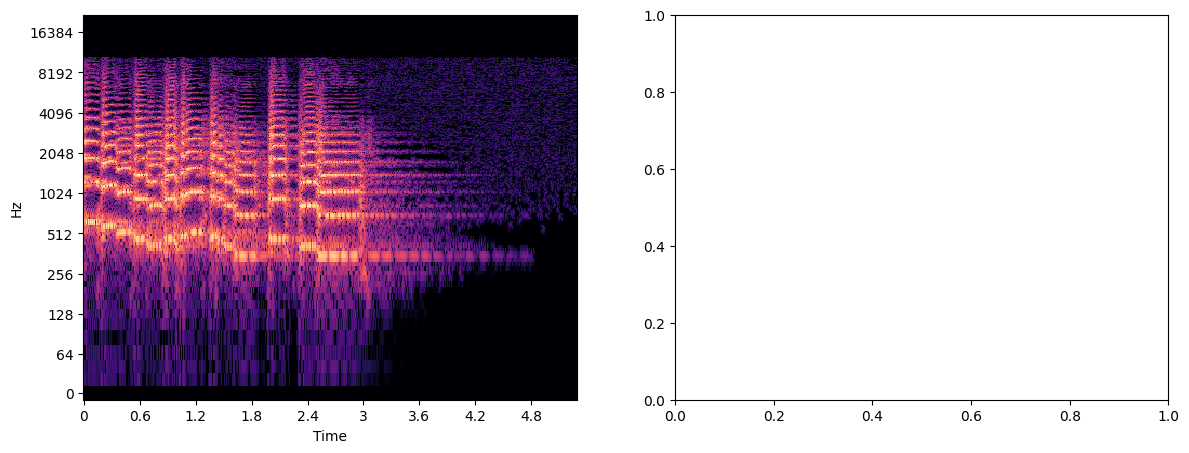

In [26]:
# D = librosa.amplitude_to_db(np.abs(librosa.stft(train_data[0][0].cpu().detach().numpy(), n_fft=2048*4)), ref=np.max)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
img = librosa.display.specshow(librosa.amplitude_to_db(repr_encoder[0,1].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[0], sr=44100)
times = librosa.times_like(repr_encoder[0,0].cpu().numpy(), sr=sr)
img = librosa.display.specshow(librosa.amplitude_to_db(spec_rec[0,1].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[1], sr=44100)

plt.tight_layout()
plt.show()

In [27]:
wv_rec = realimag2wv(spec_rec, hparams.hop, 4)

In [27]:
print('Original')
IPython.display.display(IPython.display.Audio(wv.cpu().numpy(), rate=sr))
print('Reconstructed')
IPython.display.display(IPython.display.Audio(wv_rec.squeeze().cpu().numpy(), rate=sr))

Original


Reconstructed
